In [26]:
from keras.layers import Input, Conv2D, UpSampling2D
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Input
import keras.backend as K
import sys
import os
import numpy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import Callback
import numpy as np
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Input
from keras.utils.data_utils import get_file
import keras.backend as K
import h5py
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_lfw_people
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow import keras

In [4]:
def decoder_layers(inputs, layer):
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
    if layer == 1:
        return x

    x = UpSampling2D((2, 2), name='decoder_block4_upsample')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv4')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
    if layer == 2:
        return x

    x = UpSampling2D((2, 2), name='decoder_block3_upsample')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv4')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
    if layer == 3:
        return x

    x = UpSampling2D((2, 2), name='decoder_block2_upsample')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv2')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
    if layer == 4:
        return x

    x = UpSampling2D((2, 2), name='decoder_block1_upsample')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
    if layer == 5:
        return x

## Problems with the above code

The above code does not create the layers in the correct cases. What we want if the reverse order of VGG19 starting with the last used layer and ending with the first layer of VGG. For instances if we stopped at layer 4 (conv4_1) we will start decoding with conv4_1 and then upsample and make our way though to the beginning of VGG. 

In [5]:
def decoder_layers(inputs, layer):
    
    x = None
    if layer == 5:
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
        x = UpSampling2D((2, 2), name='decoder_block4_upsample')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv4')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    
    if layer >= 4:
        if x is None:
            x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(inputs)
        else:
            x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
        x = UpSampling2D((2, 2), name='decoder_block3_upsample')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv4')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
        
    if layer >= 3:
        if x is None:
            x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(inputs)
        else:
            x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
        x = UpSampling2D((2, 2), name='decoder_block2_upsample')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv2')(x)

    if layer >= 2:
        if x is None:
            x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(inputs)
        else:
            x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
        x = UpSampling2D((2, 2), name='decoder_block1_upsample')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv2')(x)
    
    if layer >= 1:
        if x is None:
            x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(inputs)
        else:
            x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
    return x

In [6]:
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

MEAN_PIXEL = np.array([103.939, 116.779, 123.68])

WEIGHTS_PATH = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models',
                        file_hash='253f8cb515780f3b799900260a226db6')

def vgg_layers(inputs, target_layer):
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    if target_layer == 1:
        return x
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    if target_layer == 2:
        return x
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    if target_layer == 3:
        return x
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    if target_layer == 4:
        return x
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    
    return x


def load_weights(model):
    f = h5py.File(WEIGHTS_PATH)
    layer_names = [name for name in f.attrs['layer_names']]

    for layer in model.layers:
        b_name = layer.name.encode()
        if b_name in layer_names:
            g = f[b_name]
            weights = [g[name] for name in g.attrs['weight_names']]
            layer.set_weights(weights)
            layer.trainable = False

    f.close()


def VGG19(input_tensor=None, input_shape=None, target_layer=1):
    """
    VGG19, up to the target layer (1 for relu1_1, 2 for relu2_1, etc.)
    """
    if input_tensor is None:
        inputs = Input(shape=input_shape)
    else:
        inputs = Input(tensor=input_tensor, shape=input_shape)
    model = Model(inputs, vgg_layers(inputs, target_layer), name='vgg19')
    load_weights(model)
    return model


def preprocess_input(x):
    # Convert 'RGB' -> 'BGR'
    if type(x) is np.ndarray:
        x = x[..., ::-1]
    else:
        x = tf.reverse(x, [-1])

    return x - MEAN_PIXEL


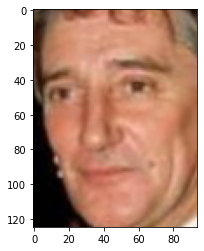

In [7]:
import matplotlib.pyplot as plt 

lfw_people = fetch_lfw_people(min_faces_per_person=1, resize=1, color=True)
lfw_people = lfw_people.images
lfw_people = lfw_people.astype('uint8')
plt.imshow(lfw_people[85])

In [8]:
lfw_people.shape

(13233, 125, 94, 3)

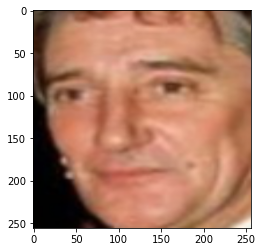

In [9]:
img = lfw_people[85].astype('uint8')
plt.imshow(cv2.resize(img, dsize=(256,256)))

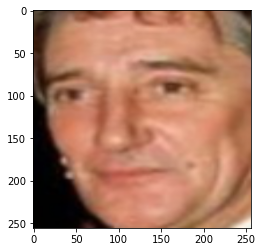

CPU times: user 2.39 s, sys: 821 ms, total: 3.22 s
Wall time: 3.21 s


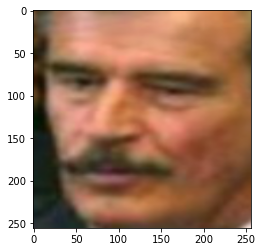

In [10]:
%%time
resized_faces = []
for face in lfw_people:
    img = face.astype('uint8')
    resized_faces.append(cv2.resize(img, dsize=(256,256)))
    
resized_faces = np.array(resized_faces)

img = resized_faces[85].astype('uint8')
plt.imshow(cv2.resize(img, dsize=(256,256)))
plt.show()

img = resized_faces[86].astype('uint8')
plt.imshow(cv2.resize(img, dsize=(256,256)))

In [104]:
LAMBDA=1

def l2_loss(x):
    return K.sum(K.square(x)) / 2

class EncoderDecoder:
    def __init__(self, input_shape=(256,256,3), target_layer=5, decoder_path=None):

        self.input_shape = input_shape
        self.target_layer = target_layer

        self.encoder = VGG19(input_shape=input_shape, target_layer=target_layer)
        if decoder_path:
            self.decoder = load_model(decoder_path)
        else:
            self.decoder = self.create_decoder(target_layer)

        self.model = Sequential()
        self.model.add(self.encoder)
        self.model.add(self.decoder)
        
        self.loss = self.create_loss_fn(self.encoder)
        
        self.model.compile('adam', self.loss)
        
        
    def create_loss_fn(self, encoder):
        def get_encodings(inputs):
            encoder = VGG19(inputs, self.input_shape, self.target_layer)
            return encoder.output

        def loss(img_in, img_out):
            encoding_in = get_encodings(img_in)
            encoding_out = get_encodings(img_out)
            return l2_loss(img_out - img_in) + \
                   LAMBDA*l2_loss(encoding_out - encoding_in)
        return loss

    def create_decoder(self, target_layer):
        inputs = Input(shape=self.encoder.output_shape[1:], name="decoder_input")
        layers = decoder_layers(inputs, target_layer)
        outputz = Conv2D(3, (3, 3), activation='relu', padding='same',
                        name='decoder_out')(layers)
        return Model(inputs, outputz, name='decoder_%s' % target_layer)
    
    def export_decoder(self):
        self.decoder.save('decoder_%s.h5' % self.target_layer)
    def export_model(self):
        self.model.save('Block%sModel' % self.target_layer)
    
    def load_decoder(self):
        self.decoder = keras.models.load_model('decoder_%s.h5' % self.target_layer)
        self.decoder.compile('adam', self.loss)
        self.model.compile('adam', self.loss)

In [105]:
encoder_decoder = EncoderDecoder(input_shape=(256, 256, 3), target_layer=2)

In [106]:
encoder_decoder.load_decoder()

In [107]:
encoder_decoder.decoder.summary()

Model: "decoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 128, 128, 128)]   0         
_________________________________________________________________
decoder_block2_conv1 (Conv2D (None, 128, 128, 128)     147584    
_________________________________________________________________
decoder_block1_upsample (UpS (None, 256, 256, 128)     0         
_________________________________________________________________
decoder_block1_conv2 (Conv2D (None, 256, 256, 64)      73792     
_________________________________________________________________
decoder_block1_conv1 (Conv2D (None, 256, 256, 64)      36928     
_________________________________________________________________
decoder_out (Conv2D)         (None, 256, 256, 3)       1731      
Total params: 260,035
Trainable params: 260,035
Non-trainable params: 0
___________________________________________________

6460.4297


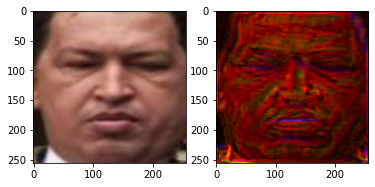

7387.516


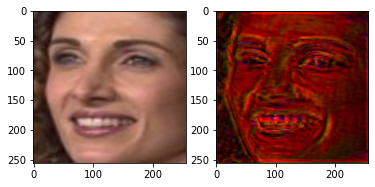

In [115]:
encoder_decoder = EncoderDecoder(input_shape=(256, 256, 3), target_layer=2)
encoder_decoder.load_decoder()
plot_img_decoder_encoder(resized_faces[80], encoder_decoder.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder.model)

In [53]:
encoder_decoder.export_model()

This part we heavily modified cause we didn't understand Callbacks and didn't want to use a generator

In [13]:
encoder_decoder = EncoderDecoder(input_shape=(256, 256, 3), target_layer=2)

In [14]:
encoder_decoder.encoder.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
Total params: 112,576
Trainable params: 0
Non-trainable params: 112,576
_________________________________________________________________


In [15]:
encoder_decoder.decoder.summary()

Model: "decoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 128, 128, 128)     0         
_________________________________________________________________
decoder_block2_conv1 (Conv2D (None, 128, 128, 128)     147584    
_________________________________________________________________
decoder_block1_upsample (UpS (None, 256, 256, 128)     0         
_________________________________________________________________
decoder_block1_conv2 (Conv2D (None, 256, 256, 64)      73792     
_________________________________________________________________
decoder_block1_conv1 (Conv2D (None, 256, 256, 64)      36928     
_________________________________________________________________
decoder_out (Conv2D)         (None, 256, 256, 3)       1731      
Total params: 260,035
Trainable params: 260,035
Non-trainable params: 0
___________________________________________________

In [16]:
encoder_decoder.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 128, 128, 128)     112576    
_________________________________________________________________
decoder_2 (Model)            (None, 256, 256, 3)       260035    
Total params: 372,611
Trainable params: 260,035
Non-trainable params: 112,576
_________________________________________________________________


In [ ]:
X = resized_faces
y = resized_faces
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
history = encoder_decoder.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=5, batch_size=5)

In [16]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12.8,4.8))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
def plot_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12.8,4.8))
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.show()

#plot_history(history)

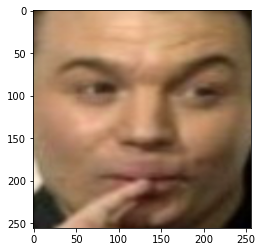

In [66]:
lfw_people = lfw_people.astype(int)
plt.imshow(resized_faces[80])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


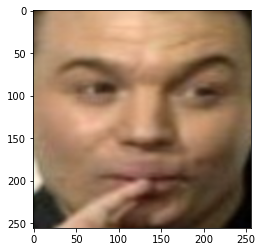

In [67]:
sample = resized_faces[80].reshape(1, 256, 256,3)
out_sample = encoder_decoder.model.predict(sample)
plt.imshow(out_sample[0].astype(int))

In [27]:
np.mean(np.square(out_sample - sample))

18.04685

In [40]:

import PIL.Image

2022-04-01 20:50:55.463352: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-04-01 20:50:55.868123: W tensorflow/stream_executor/gpu/redzone_allocator.cc:312] Not found: ./bin/ptxas not found
Relying on driver to perform ptx compilation. This message will be only logged once.
2022-04-01 20:50:55.880777: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


42879.207


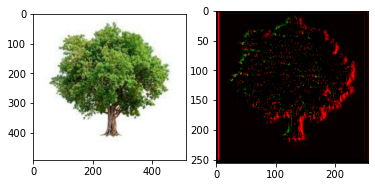

12712.37


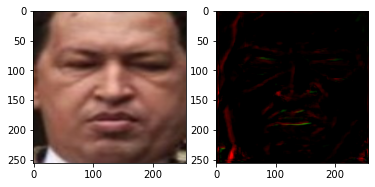

14140.91


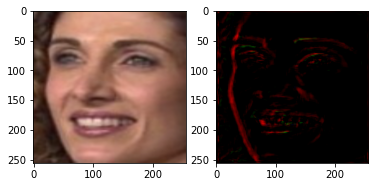

In [41]:
# This is from 05c UniversalStyleTransfer.ipynb
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def plot_img_decoder_encoder(img, model):
    input_img = np.asarray(img)
    input_img = cv2.resize(input_img, dsize=(256,256))
    input_img = input_img.reshape(1, 256, 256,3)
    out_sample = model.predict(input_img)
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(np.clip(out_sample[0].astype(int), 0, 255))
    print(np.mean(np.square(out_sample - input_img)))
    plt.show()
    
    
img = tensor_to_image(load_img("./tree.jpg"))
plot_img_decoder_encoder(img, encoder_decoder.model)

plot_img_decoder_encoder(resized_faces[80], encoder_decoder.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder.model)

In [54]:
# Run a few different models just to see

In [99]:
%%time
encoder_decoder_3 = EncoderDecoder(input_shape=(256, 256, 3), target_layer=3)
history_3 = encoder_decoder_3.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=160, batch_size=5, verbose=False)

CPU times: user 4h 58min 20s, sys: 1min 58s, total: 5h 19s
Wall time: 9h 15min 34s


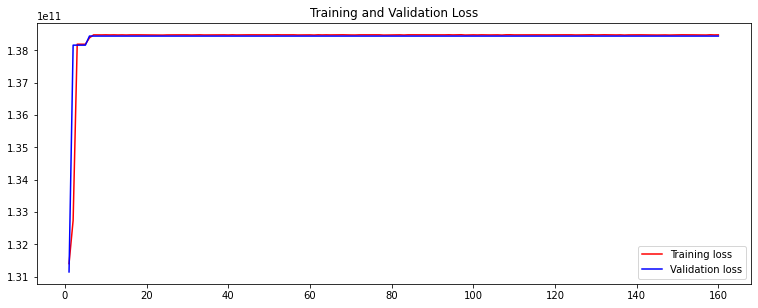

In [100]:
plot_history(history_3)

13246.384


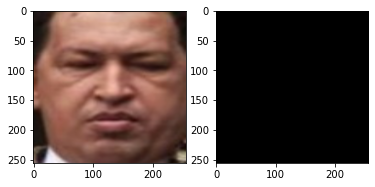

14788.258


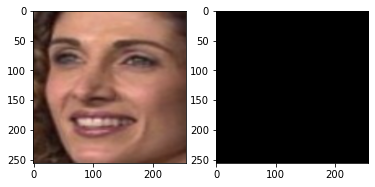

In [101]:

plot_img_decoder_encoder(resized_faces[80], encoder_decoder_3.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder_3.model)

In [105]:
# Not converged, try again but continue from where we left off.

In [103]:
%%time
# Continue where we left off above.
history_3 = encoder_decoder_3.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=160, batch_size=5, verbose=False)

CPU times: user 4h 59min 12s, sys: 2min 10s, total: 5h 1min 22s
Wall time: 9h 16min 14s


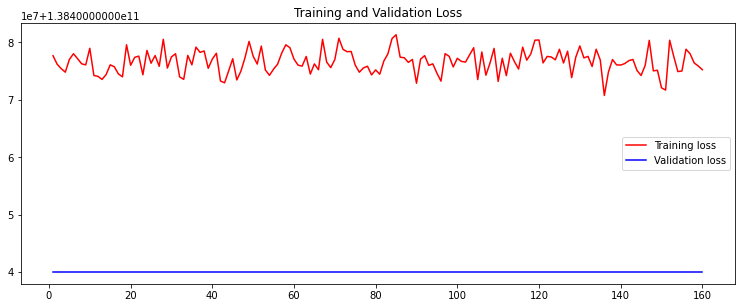

In [104]:
plot_history(history_3)

13246.384


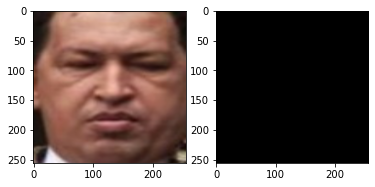

14788.258


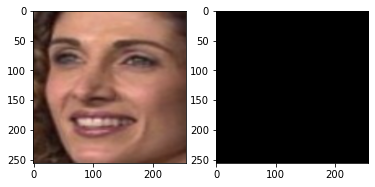

In [107]:

plot_img_decoder_encoder(resized_faces[80], encoder_decoder_3.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder_3.model)

In [108]:
encoder_decoder_3.export_decoder()

In [109]:
# Not converged, try again but continue from where we left off.

In [110]:
%%time
# Continue where we left off above.
history_3 = encoder_decoder_3.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=160, batch_size=5, verbose=False)

CPU times: user 5h 2min 56s, sys: 1min 56s, total: 5h 4min 52s
Wall time: 9h 19min 44s


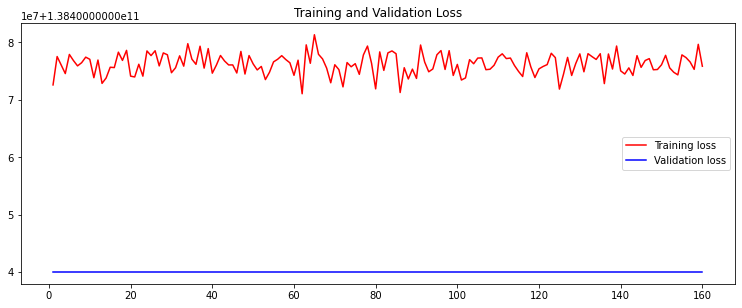

In [111]:
plot_history(history_3)

13246.384


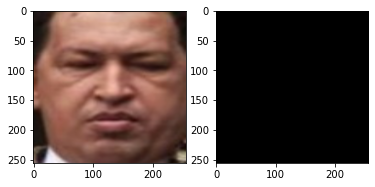

14788.258


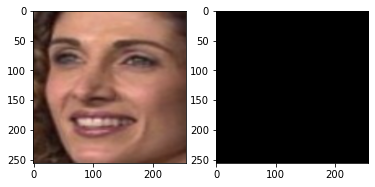

In [112]:

plot_img_decoder_encoder(resized_faces[80], encoder_decoder_3.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder_3.model)

In [113]:
encoder_decoder_3.export_decoder()

In [114]:
%%time
# Continue where we left off above.
history_3 = encoder_decoder_3.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=160, batch_size=5, verbose=False)

CPU times: user 4h 59min 43s, sys: 2min 23s, total: 5h 2min 6s
Wall time: 9h 17min 8s


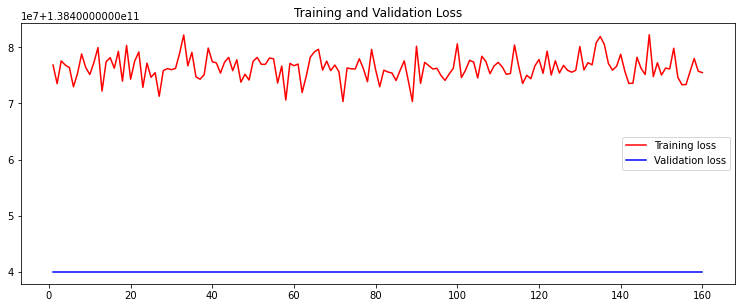

In [115]:
plot_history(history_3)

13246.384


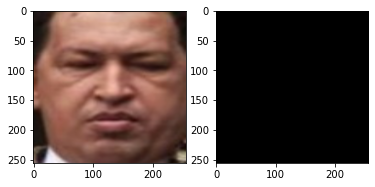

14788.258


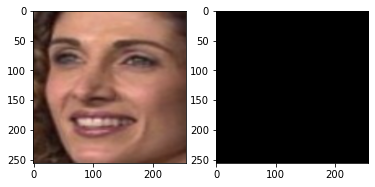

In [116]:

plot_img_decoder_encoder(resized_faces[80], encoder_decoder_3.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder_3.model)

In [117]:
encoder_decoder_3.export_decoder()

In [118]:
%%time
# Continue where we left off above.
history_3 = encoder_decoder_3.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=160, batch_size=5, verbose=False)

CPU times: user 5h 2min 52s, sys: 2min 1s, total: 5h 4min 54s
Wall time: 9h 19min 51s


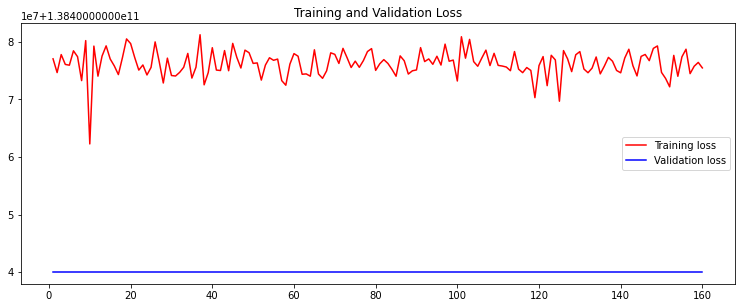

In [119]:
plot_history(history_3)

13246.384


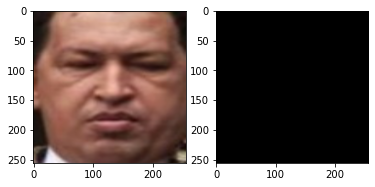

14788.258


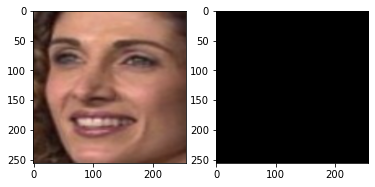

In [120]:

plot_img_decoder_encoder(resized_faces[80], encoder_decoder_3.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder_3.model)

In [121]:
encoder_decoder_3.export_decoder()

In [122]:
%%time
# Continue where we left off above.
history_3 = encoder_decoder_3.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=160, batch_size=5, verbose=False)

CPU times: user 5h 6min 24s, sys: 2min 15s, total: 5h 8min 39s
Wall time: 9h 22min 59s


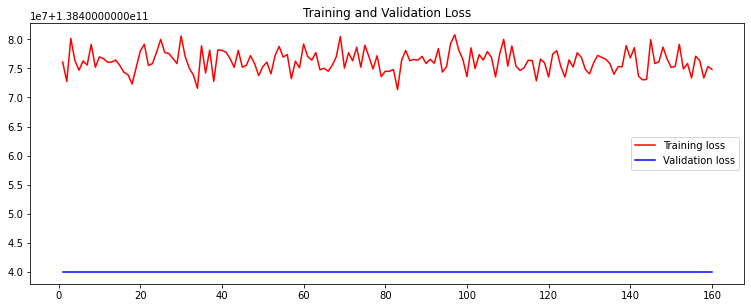

In [123]:
plot_history(history_3)

13246.384


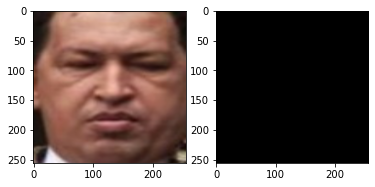

14788.258


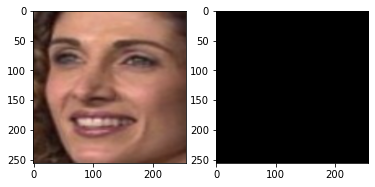

In [124]:

plot_img_decoder_encoder(resized_faces[80], encoder_decoder_3.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder_3.model)

In [125]:
encoder_decoder_3.export_decoder()

In [126]:
%%time
# Continue where we left off above.
history_3 = encoder_decoder_3.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=160, batch_size=5, verbose=False)

CPU times: user 5h 6min 39s, sys: 2min 2s, total: 5h 8min 41s
Wall time: 9h 23min 8s


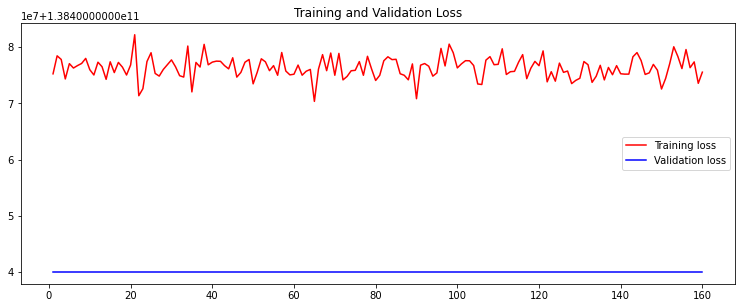

In [127]:
plot_history(history_3)

13246.384


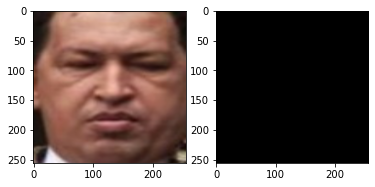

14788.258


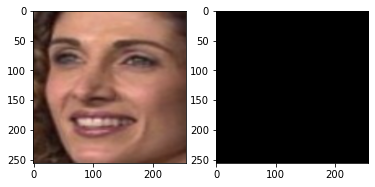

In [128]:

plot_img_decoder_encoder(resized_faces[80], encoder_decoder_3.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder_3.model)

In [129]:
encoder_decoder_3.export_decoder()

In [13]:
%%time
X = resized_faces
y = resized_faces
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
encoder_decoder_2 = EncoderDecoder(input_shape=(256, 256, 3), target_layer=2)
history_2 = encoder_decoder_2.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=10, batch_size=5, verbose=False)

2022-04-01 18:56:15.544430: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-04-01 18:56:15.822933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 18:56:15.823823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2022-04-01 18:56:15.824058: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-04-01 18:56:15.825713: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-04-01 18:56:15.827337: I tensorflow/stream_executor

CPU times: user 14min 56s, sys: 10.9 s, total: 15min 6s
Wall time: 27min 21s


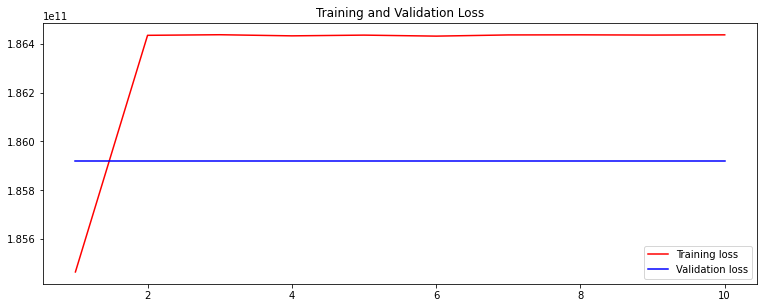

In [17]:
plot_history(history_2)

In [24]:
history_2 = encoder_decoder_2.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=10, batch_size=5, verbose=False)

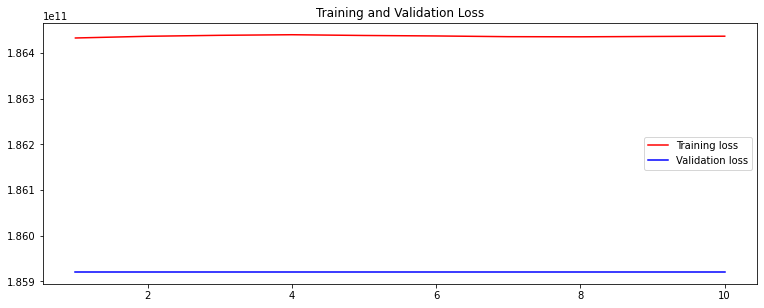

In [25]:
plot_history(history_2)

In [26]:
history_2 = encoder_decoder_2.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=20, batch_size=5, verbose=False)

KeyboardInterrupt: 

In [96]:
encoder_decoder_2.export_decoder()

13246.384


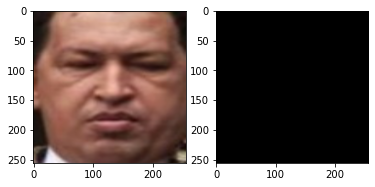

14788.258


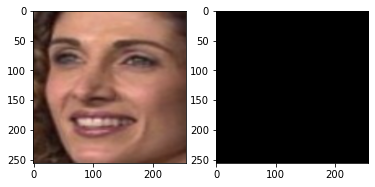

In [23]:

plot_img_decoder_encoder(resized_faces[80], encoder_decoder_2.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder_2.model)

In [91]:
encoder_decoder_1 = EncoderDecoder(input_shape=(256, 256, 3), target_layer=1)
history_1 = encoder_decoder_1.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=20, batch_size=5, verbose=False)

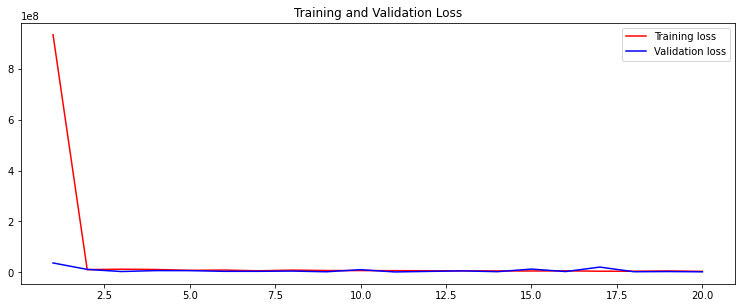

In [92]:
plot_history(history_1)

In [95]:
encoder_decoder_1.export_decoder()

In [22]:

plot_img_decoder_encoder(resized_faces[80], encoder_decoder_1.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder_1.model)

NameError: name 'encoder_decoder_1' is not defined

In [25]:
encoder_decoder = EncoderDecoder(input_shape=(256, 256, 3), target_layer=3)

In [26]:
encoder_decoder.encoder.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [27]:
encoder_decoder.decoder.summary()

Model: "decoder_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 64, 64, 256)       0         
_________________________________________________________________
decoder_block3_conv1 (Conv2D (None, 64, 64, 256)       590080    
_________________________________________________________________
decoder_block2_upsample (UpS (None, 128, 128, 256)     0         
_________________________________________________________________
decoder_block2_conv2 (Conv2D (None, 128, 128, 128)     295040    
_________________________________________________________________
decoder_block2_conv1 (Conv2D (None, 128, 128, 128)     147584    
_________________________________________________________________
decoder_block1_upsample (UpS (None, 256, 256, 128)     0         
_________________________________________________________________
decoder_block1_conv2 (Conv2D (None, 256, 256, 64)      73

______________________

In [30]:
encoder_decoder = None